In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "uni80"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 215
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 287
Categorical Columns: 8


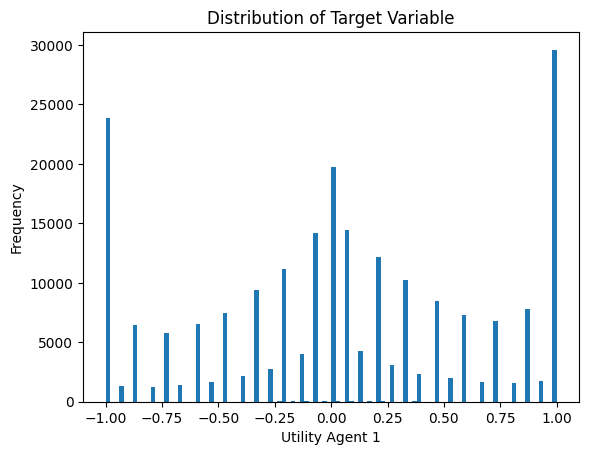

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.495289


[200]	valid_0's rmse: 0.47717


[300]	valid_0's rmse: 0.467404


[400]	valid_0's rmse: 0.461155


[500]	valid_0's rmse: 0.456329


[600]	valid_0's rmse: 0.452157


[700]	valid_0's rmse: 0.448634


[800]	valid_0's rmse: 0.446193


[900]	valid_0's rmse: 0.444049


[1000]	valid_0's rmse: 0.441918


[1100]	valid_0's rmse: 0.440411


[1200]	valid_0's rmse: 0.43905


[1300]	valid_0's rmse: 0.438171


[1400]	valid_0's rmse: 0.437102


[1500]	valid_0's rmse: 0.436329


[1600]	valid_0's rmse: 0.435524


[1700]	valid_0's rmse: 0.434721


[1800]	valid_0's rmse: 0.434114


[1900]	valid_0's rmse: 0.433545


[2000]	valid_0's rmse: 0.4331


[2100]	valid_0's rmse: 0.432664


[2200]	valid_0's rmse: 0.432258


[2300]	valid_0's rmse: 0.431964


[2400]	valid_0's rmse: 0.431729


[2500]	valid_0's rmse: 0.43146


[2600]	valid_0's rmse: 0.431153


[2700]	valid_0's rmse: 0.430981


[2800]	valid_0's rmse: 0.430642


[2900]	valid_0's rmse: 0.430346


[3000]	valid_0's rmse: 0.430179


[3100]	valid_0's rmse: 0.42996


[3200]	valid_0's rmse: 0.429674


[3300]	valid_0's rmse: 0.42946


[3400]	valid_0's rmse: 0.429363


[3500]	valid_0's rmse: 0.429131


[3600]	valid_0's rmse: 0.428946


[3700]	valid_0's rmse: 0.428814


[3800]	valid_0's rmse: 0.428766


[3900]	valid_0's rmse: 0.42863


[4000]	valid_0's rmse: 0.428483


[4100]	valid_0's rmse: 0.428299


[4200]	valid_0's rmse: 0.428111


[4300]	valid_0's rmse: 0.427983


[4400]	valid_0's rmse: 0.427896


[4500]	valid_0's rmse: 0.427803


[4600]	valid_0's rmse: 0.427812


[4700]	valid_0's rmse: 0.427667


[4800]	valid_0's rmse: 0.427632


[4900]	valid_0's rmse: 0.427456


[5000]	valid_0's rmse: 0.427345


[5100]	valid_0's rmse: 0.427264


[5200]	valid_0's rmse: 0.427233


[5300]	valid_0's rmse: 0.427115


[5400]	valid_0's rmse: 0.427072


[5500]	valid_0's rmse: 0.427052


[5600]	valid_0's rmse: 0.42702


[5700]	valid_0's rmse: 0.427028


[5800]	valid_0's rmse: 0.42697


[5900]	valid_0's rmse: 0.426968


[6000]	valid_0's rmse: 0.426944


[6100]	valid_0's rmse: 0.426911


[6200]	valid_0's rmse: 0.426854


[6300]	valid_0's rmse: 0.426823


[6400]	valid_0's rmse: 0.426832


[6500]	valid_0's rmse: 0.426804


[6600]	valid_0's rmse: 0.426778


[6700]	valid_0's rmse: 0.426738


[6800]	valid_0's rmse: 0.426628


[6900]	valid_0's rmse: 0.426538


[7000]	valid_0's rmse: 0.426482


[7100]	valid_0's rmse: 0.426434


[7200]	valid_0's rmse: 0.426371


[7300]	valid_0's rmse: 0.42635


[7400]	valid_0's rmse: 0.426329


[7500]	valid_0's rmse: 0.426385


[7600]	valid_0's rmse: 0.426405


[7700]	valid_0's rmse: 0.426428


[7800]	valid_0's rmse: 0.426421


[7900]	valid_0's rmse: 0.426433


[8000]	valid_0's rmse: 0.426383


[8100]	valid_0's rmse: 0.426385


[8200]	valid_0's rmse: 0.426398


[8300]	valid_0's rmse: 0.426381


[8400]	valid_0's rmse: 0.426434


[8500]	valid_0's rmse: 0.426393


[8600]	valid_0's rmse: 0.426334


[8700]	valid_0's rmse: 0.426409


[8800]	valid_0's rmse: 0.426374


[8900]	valid_0's rmse: 0.426326


[9000]	valid_0's rmse: 0.42632


[9100]	valid_0's rmse: 0.426321


[9200]	valid_0's rmse: 0.426284


[9300]	valid_0's rmse: 0.426274


[9400]	valid_0's rmse: 0.426198


[9500]	valid_0's rmse: 0.426207


[9600]	valid_0's rmse: 0.4262


[9700]	valid_0's rmse: 0.426206


[9800]	valid_0's rmse: 0.426206


[9900]	valid_0's rmse: 0.426237


[10000]	valid_0's rmse: 0.426216


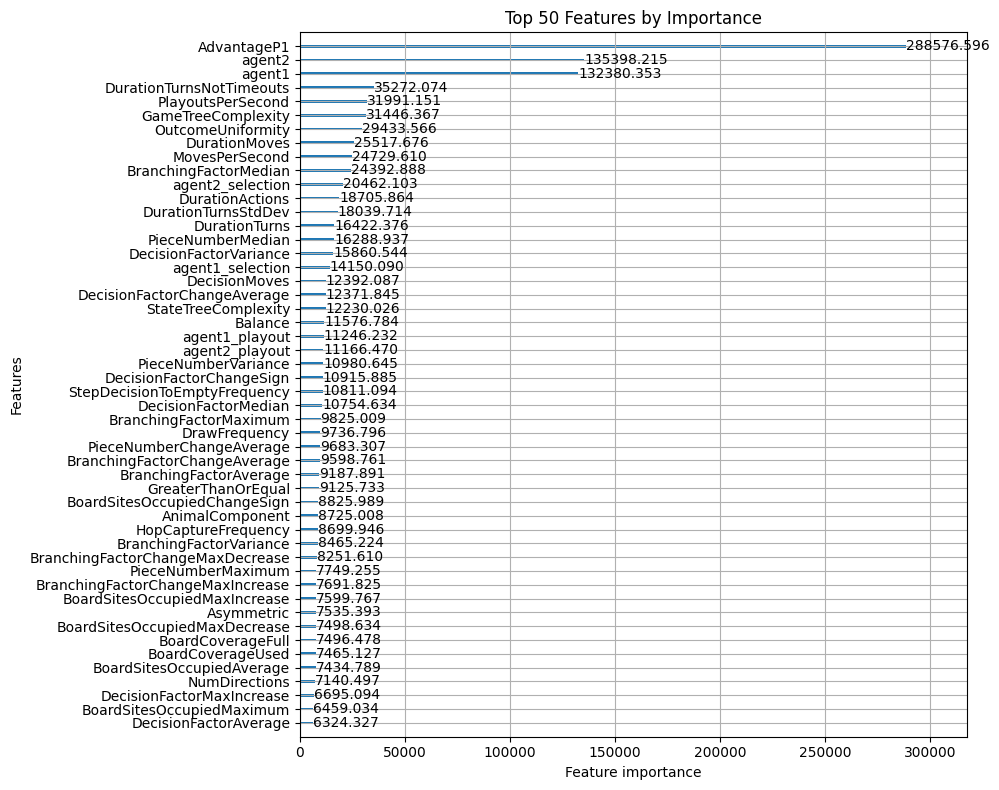

Fold 1 - RMSE: 0.42568909751364725
Fold 2


[100]	valid_0's rmse: 0.509961


[200]	valid_0's rmse: 0.492356


[300]	valid_0's rmse: 0.48369


[400]	valid_0's rmse: 0.477086


[500]	valid_0's rmse: 0.472515


[600]	valid_0's rmse: 0.469514


[700]	valid_0's rmse: 0.466872


[800]	valid_0's rmse: 0.464874


[900]	valid_0's rmse: 0.4635


[1000]	valid_0's rmse: 0.462682


[1100]	valid_0's rmse: 0.46139


[1200]	valid_0's rmse: 0.460136


[1300]	valid_0's rmse: 0.459688


[1400]	valid_0's rmse: 0.459107


[1500]	valid_0's rmse: 0.458314


[1600]	valid_0's rmse: 0.457887


[1700]	valid_0's rmse: 0.457389


[1800]	valid_0's rmse: 0.457016


[1900]	valid_0's rmse: 0.45662


[2000]	valid_0's rmse: 0.456221


[2100]	valid_0's rmse: 0.455985


[2200]	valid_0's rmse: 0.45568


[2300]	valid_0's rmse: 0.455292


[2400]	valid_0's rmse: 0.45502


[2500]	valid_0's rmse: 0.454774


[2600]	valid_0's rmse: 0.454612


[2700]	valid_0's rmse: 0.454396


[2800]	valid_0's rmse: 0.454153


[2900]	valid_0's rmse: 0.453884


[3000]	valid_0's rmse: 0.453684


[3100]	valid_0's rmse: 0.453366


[3200]	valid_0's rmse: 0.453141


[3300]	valid_0's rmse: 0.45294


[3400]	valid_0's rmse: 0.452713


[3500]	valid_0's rmse: 0.452586


[3600]	valid_0's rmse: 0.452423


[3700]	valid_0's rmse: 0.452247


[3800]	valid_0's rmse: 0.451967


[3900]	valid_0's rmse: 0.451723


[4000]	valid_0's rmse: 0.451623


[4100]	valid_0's rmse: 0.451559


[4200]	valid_0's rmse: 0.451549


[4300]	valid_0's rmse: 0.451422


[4400]	valid_0's rmse: 0.451279


[4500]	valid_0's rmse: 0.451133


[4600]	valid_0's rmse: 0.450997


[4700]	valid_0's rmse: 0.450833


[4800]	valid_0's rmse: 0.450754


[4900]	valid_0's rmse: 0.450647


[5000]	valid_0's rmse: 0.450514


[5100]	valid_0's rmse: 0.450345


[5200]	valid_0's rmse: 0.450336


[5300]	valid_0's rmse: 0.450178


[5400]	valid_0's rmse: 0.450095


[5500]	valid_0's rmse: 0.450042


[5600]	valid_0's rmse: 0.450106


[5700]	valid_0's rmse: 0.450108


[5800]	valid_0's rmse: 0.450079


[5900]	valid_0's rmse: 0.450066


[6000]	valid_0's rmse: 0.450024


[6100]	valid_0's rmse: 0.449851


[6200]	valid_0's rmse: 0.449695


[6300]	valid_0's rmse: 0.44964


[6400]	valid_0's rmse: 0.449586


[6500]	valid_0's rmse: 0.449545


[6600]	valid_0's rmse: 0.449493


[6700]	valid_0's rmse: 0.449483


[6800]	valid_0's rmse: 0.449441


[6900]	valid_0's rmse: 0.449482


[7000]	valid_0's rmse: 0.449487


[7100]	valid_0's rmse: 0.449445


[7200]	valid_0's rmse: 0.449341


[7300]	valid_0's rmse: 0.449307


[7400]	valid_0's rmse: 0.449241


[7500]	valid_0's rmse: 0.449194


[7600]	valid_0's rmse: 0.449191


[7700]	valid_0's rmse: 0.449203


[7800]	valid_0's rmse: 0.449164


[7900]	valid_0's rmse: 0.449176


[8000]	valid_0's rmse: 0.449096


[8100]	valid_0's rmse: 0.449096


[8200]	valid_0's rmse: 0.449011


[8300]	valid_0's rmse: 0.449026


[8400]	valid_0's rmse: 0.449042


[8500]	valid_0's rmse: 0.448932


[8600]	valid_0's rmse: 0.448908


[8700]	valid_0's rmse: 0.448806


[8800]	valid_0's rmse: 0.44879


[8900]	valid_0's rmse: 0.448717


[9000]	valid_0's rmse: 0.448665


[9100]	valid_0's rmse: 0.448597


[9200]	valid_0's rmse: 0.448589


[9300]	valid_0's rmse: 0.448615


[9400]	valid_0's rmse: 0.44852


[9500]	valid_0's rmse: 0.448415


[9600]	valid_0's rmse: 0.448397


[9700]	valid_0's rmse: 0.448311


[9800]	valid_0's rmse: 0.448365


[9900]	valid_0's rmse: 0.448335


[10000]	valid_0's rmse: 0.448324


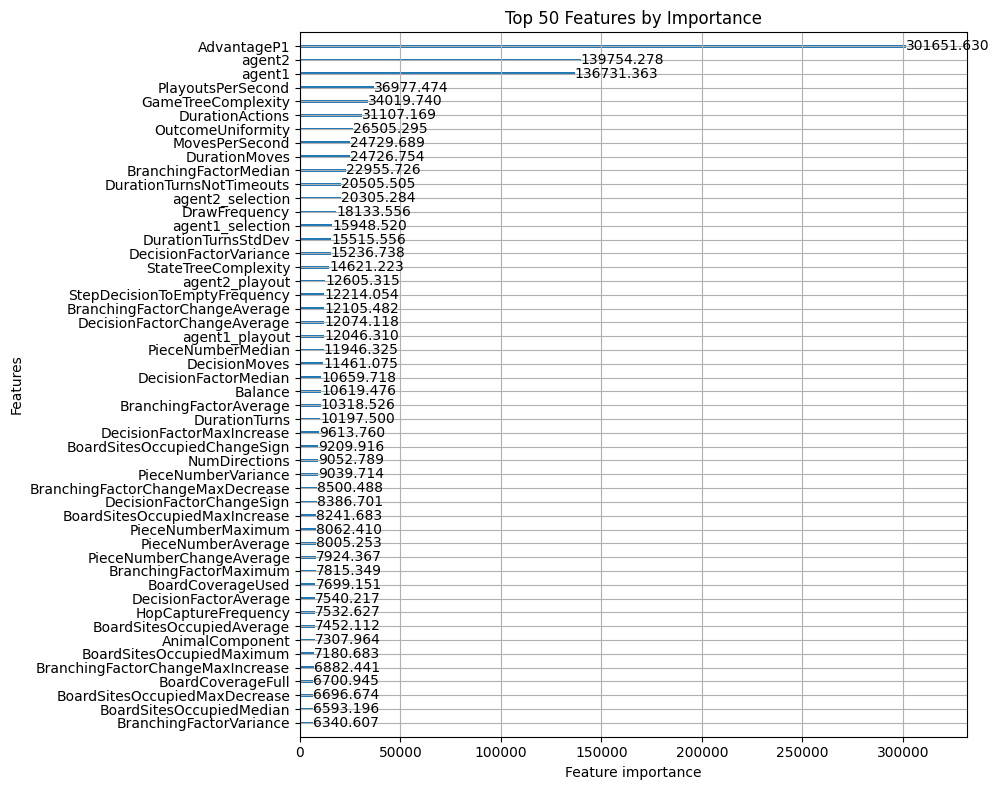

Fold 2 - RMSE: 0.4477459367681129
Fold 3


[100]	valid_0's rmse: 0.513161


[200]	valid_0's rmse: 0.485405


[300]	valid_0's rmse: 0.473905


[400]	valid_0's rmse: 0.466709


[500]	valid_0's rmse: 0.463104


[600]	valid_0's rmse: 0.459821


[700]	valid_0's rmse: 0.456999


[800]	valid_0's rmse: 0.454897


[900]	valid_0's rmse: 0.452895


[1000]	valid_0's rmse: 0.451273


[1100]	valid_0's rmse: 0.449972


[1200]	valid_0's rmse: 0.448934


[1300]	valid_0's rmse: 0.447584


[1400]	valid_0's rmse: 0.446621


[1500]	valid_0's rmse: 0.445916


[1600]	valid_0's rmse: 0.445369


[1700]	valid_0's rmse: 0.444898


[1800]	valid_0's rmse: 0.444328


[1900]	valid_0's rmse: 0.443815


[2000]	valid_0's rmse: 0.443319


[2100]	valid_0's rmse: 0.442904


[2200]	valid_0's rmse: 0.442279


[2300]	valid_0's rmse: 0.441926


[2400]	valid_0's rmse: 0.441556


[2500]	valid_0's rmse: 0.441119


[2600]	valid_0's rmse: 0.440753


[2700]	valid_0's rmse: 0.440521


[2800]	valid_0's rmse: 0.440178


[2900]	valid_0's rmse: 0.439972


[3000]	valid_0's rmse: 0.439759


[3100]	valid_0's rmse: 0.439409


[3200]	valid_0's rmse: 0.439233


[3300]	valid_0's rmse: 0.439066


[3400]	valid_0's rmse: 0.438948


[3500]	valid_0's rmse: 0.438843


[3600]	valid_0's rmse: 0.438586


[3700]	valid_0's rmse: 0.43841


[3800]	valid_0's rmse: 0.438221


[3900]	valid_0's rmse: 0.438055


[4000]	valid_0's rmse: 0.437887


[4100]	valid_0's rmse: 0.437734


[4200]	valid_0's rmse: 0.437589


[4300]	valid_0's rmse: 0.437525


[4400]	valid_0's rmse: 0.437457


[4500]	valid_0's rmse: 0.437292


[4600]	valid_0's rmse: 0.437159


[4700]	valid_0's rmse: 0.436969


[4800]	valid_0's rmse: 0.436858


[4900]	valid_0's rmse: 0.436775


[5000]	valid_0's rmse: 0.43664


[5100]	valid_0's rmse: 0.436598


[5200]	valid_0's rmse: 0.436545


[5300]	valid_0's rmse: 0.436478


[5400]	valid_0's rmse: 0.436415


[5500]	valid_0's rmse: 0.436275


[5600]	valid_0's rmse: 0.436274


[5700]	valid_0's rmse: 0.436183


[5800]	valid_0's rmse: 0.436125


[5900]	valid_0's rmse: 0.436054


[6000]	valid_0's rmse: 0.436054


[6100]	valid_0's rmse: 0.435974


[6200]	valid_0's rmse: 0.435964


[6300]	valid_0's rmse: 0.435892


[6400]	valid_0's rmse: 0.435859


[6500]	valid_0's rmse: 0.435821


[6600]	valid_0's rmse: 0.43579


[6700]	valid_0's rmse: 0.435756


[6800]	valid_0's rmse: 0.435721


[6900]	valid_0's rmse: 0.435663


[7000]	valid_0's rmse: 0.435619


[7100]	valid_0's rmse: 0.435555


[7200]	valid_0's rmse: 0.435521


[7300]	valid_0's rmse: 0.435453


[7400]	valid_0's rmse: 0.435471


[7500]	valid_0's rmse: 0.435421


[7600]	valid_0's rmse: 0.435356


[7700]	valid_0's rmse: 0.43541


[7800]	valid_0's rmse: 0.435398


[7900]	valid_0's rmse: 0.435319


[8000]	valid_0's rmse: 0.435286


[8100]	valid_0's rmse: 0.435281


[8200]	valid_0's rmse: 0.435269


[8300]	valid_0's rmse: 0.435253


[8400]	valid_0's rmse: 0.435245


[8500]	valid_0's rmse: 0.435188


[8600]	valid_0's rmse: 0.435202


[8700]	valid_0's rmse: 0.4352


[8800]	valid_0's rmse: 0.435146


[8900]	valid_0's rmse: 0.435116


[9000]	valid_0's rmse: 0.43512


[9100]	valid_0's rmse: 0.4351


[9200]	valid_0's rmse: 0.43504


[9300]	valid_0's rmse: 0.434958


[9400]	valid_0's rmse: 0.434943


[9500]	valid_0's rmse: 0.434931


[9600]	valid_0's rmse: 0.434869


[9700]	valid_0's rmse: 0.434836


[9800]	valid_0's rmse: 0.434811


[9900]	valid_0's rmse: 0.434808


[10000]	valid_0's rmse: 0.434781


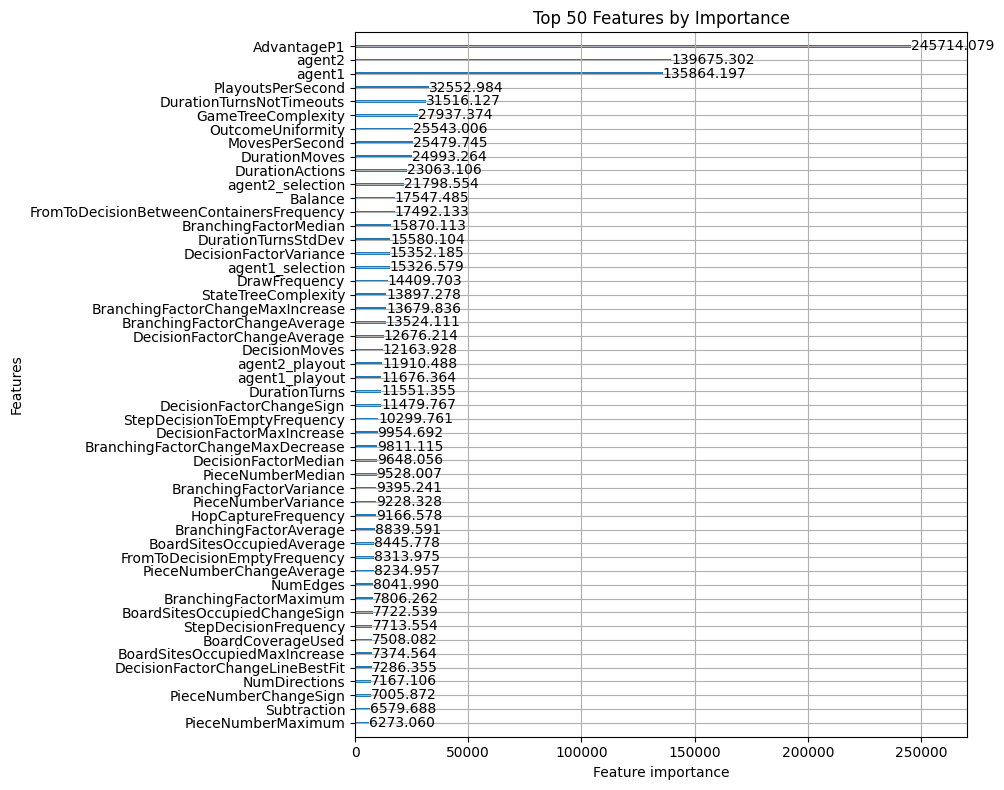

Fold 3 - RMSE: 0.4341013770647174
Fold 4


[100]	valid_0's rmse: 0.517328


[200]	valid_0's rmse: 0.492842


[300]	valid_0's rmse: 0.480605


[400]	valid_0's rmse: 0.472203


[500]	valid_0's rmse: 0.466564


[600]	valid_0's rmse: 0.462302


[700]	valid_0's rmse: 0.459451


[800]	valid_0's rmse: 0.456831


[900]	valid_0's rmse: 0.45505


[1000]	valid_0's rmse: 0.453221


[1100]	valid_0's rmse: 0.451417


[1200]	valid_0's rmse: 0.450211


[1300]	valid_0's rmse: 0.449458


[1400]	valid_0's rmse: 0.448448


[1500]	valid_0's rmse: 0.447563


[1600]	valid_0's rmse: 0.44682


[1700]	valid_0's rmse: 0.446065


[1800]	valid_0's rmse: 0.445537


[1900]	valid_0's rmse: 0.444931


[2000]	valid_0's rmse: 0.4444


[2100]	valid_0's rmse: 0.444052


[2200]	valid_0's rmse: 0.443701


[2300]	valid_0's rmse: 0.443384


[2400]	valid_0's rmse: 0.442956


[2500]	valid_0's rmse: 0.442645


[2600]	valid_0's rmse: 0.442216


[2700]	valid_0's rmse: 0.441926


[2800]	valid_0's rmse: 0.441662


[2900]	valid_0's rmse: 0.441442


[3000]	valid_0's rmse: 0.441291


[3100]	valid_0's rmse: 0.44107


[3200]	valid_0's rmse: 0.440858


[3300]	valid_0's rmse: 0.440608


[3400]	valid_0's rmse: 0.440356


[3500]	valid_0's rmse: 0.440197


[3600]	valid_0's rmse: 0.440025


[3700]	valid_0's rmse: 0.439847


[3800]	valid_0's rmse: 0.439761


[3900]	valid_0's rmse: 0.439564


[4000]	valid_0's rmse: 0.439456


[4100]	valid_0's rmse: 0.439314


[4200]	valid_0's rmse: 0.439282


[4300]	valid_0's rmse: 0.439219


[4400]	valid_0's rmse: 0.439099


[4500]	valid_0's rmse: 0.438975


[4600]	valid_0's rmse: 0.438829


[4700]	valid_0's rmse: 0.438711


[4800]	valid_0's rmse: 0.438496


[4900]	valid_0's rmse: 0.438459


[5000]	valid_0's rmse: 0.438351


[5100]	valid_0's rmse: 0.438302


[5200]	valid_0's rmse: 0.438241


[5300]	valid_0's rmse: 0.438229


[5400]	valid_0's rmse: 0.438183


[5500]	valid_0's rmse: 0.438115


[5600]	valid_0's rmse: 0.438007


[5700]	valid_0's rmse: 0.437904


[5800]	valid_0's rmse: 0.437871


[5900]	valid_0's rmse: 0.437763


[6000]	valid_0's rmse: 0.43769


[6100]	valid_0's rmse: 0.437668


[6200]	valid_0's rmse: 0.437605


[6300]	valid_0's rmse: 0.43763


[6400]	valid_0's rmse: 0.43759


[6500]	valid_0's rmse: 0.437544


[6600]	valid_0's rmse: 0.4375


[6700]	valid_0's rmse: 0.437478


[6800]	valid_0's rmse: 0.437392


[6900]	valid_0's rmse: 0.437325


[7000]	valid_0's rmse: 0.437321


[7100]	valid_0's rmse: 0.437272


[7200]	valid_0's rmse: 0.437188


[7300]	valid_0's rmse: 0.437158


[7400]	valid_0's rmse: 0.437103


[7500]	valid_0's rmse: 0.437104


[7600]	valid_0's rmse: 0.437096


[7700]	valid_0's rmse: 0.437057


[7800]	valid_0's rmse: 0.437053


[7900]	valid_0's rmse: 0.437035


[8000]	valid_0's rmse: 0.436993


[8100]	valid_0's rmse: 0.436972


[8200]	valid_0's rmse: 0.436938


[8300]	valid_0's rmse: 0.436943


[8400]	valid_0's rmse: 0.436815


[8500]	valid_0's rmse: 0.436789


[8600]	valid_0's rmse: 0.436727


[8700]	valid_0's rmse: 0.436759


[8800]	valid_0's rmse: 0.436737


[8900]	valid_0's rmse: 0.436717


[9000]	valid_0's rmse: 0.436676


[9100]	valid_0's rmse: 0.436632


[9200]	valid_0's rmse: 0.436628


[9300]	valid_0's rmse: 0.436615


[9400]	valid_0's rmse: 0.436632


[9500]	valid_0's rmse: 0.436595


[9600]	valid_0's rmse: 0.436574


[9700]	valid_0's rmse: 0.43652


[9800]	valid_0's rmse: 0.436532


[9900]	valid_0's rmse: 0.436502


[10000]	valid_0's rmse: 0.436486


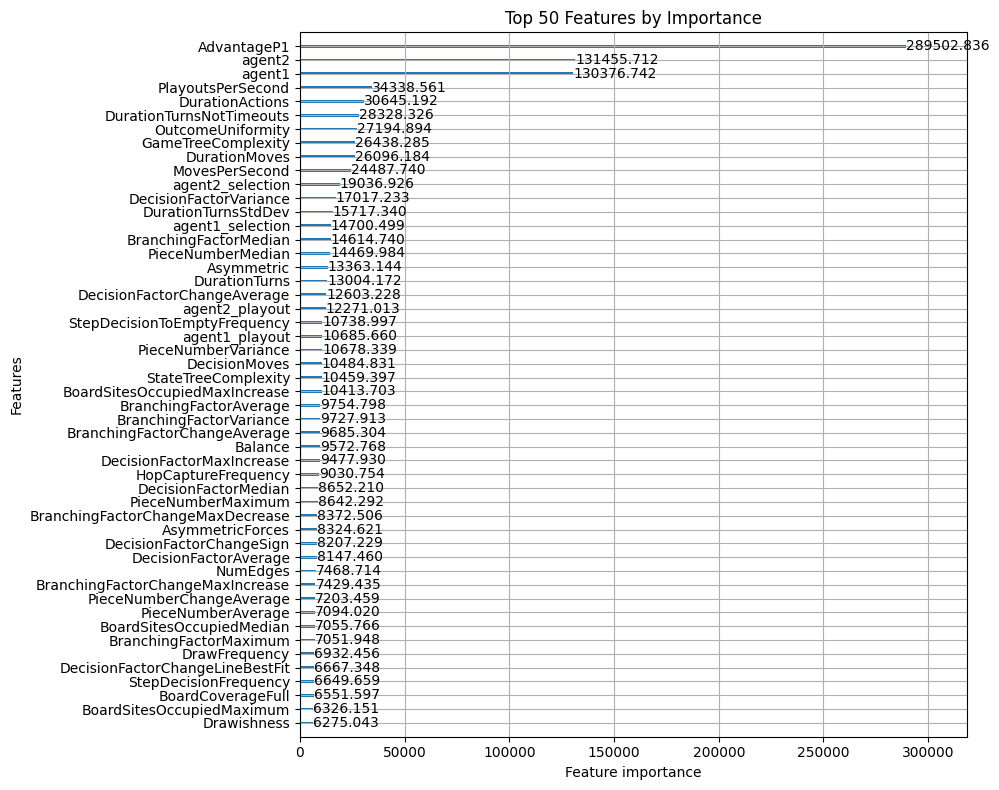

Fold 4 - RMSE: 0.4354346027540548
Fold 5


[100]	valid_0's rmse: 0.488336


[200]	valid_0's rmse: 0.467744


[300]	valid_0's rmse: 0.454028


[400]	valid_0's rmse: 0.445647


[500]	valid_0's rmse: 0.439583


[600]	valid_0's rmse: 0.434909


[700]	valid_0's rmse: 0.431138


[800]	valid_0's rmse: 0.428103


[900]	valid_0's rmse: 0.425751


[1000]	valid_0's rmse: 0.423986


[1100]	valid_0's rmse: 0.422072


[1200]	valid_0's rmse: 0.42068


[1300]	valid_0's rmse: 0.419662


[1400]	valid_0's rmse: 0.41837


[1500]	valid_0's rmse: 0.417309


[1600]	valid_0's rmse: 0.416485


[1700]	valid_0's rmse: 0.415687


[1800]	valid_0's rmse: 0.415132


[1900]	valid_0's rmse: 0.414499


[2000]	valid_0's rmse: 0.413993


[2100]	valid_0's rmse: 0.413632


[2200]	valid_0's rmse: 0.413154


[2300]	valid_0's rmse: 0.412725


[2400]	valid_0's rmse: 0.412371


[2500]	valid_0's rmse: 0.412007


[2600]	valid_0's rmse: 0.411559


[2700]	valid_0's rmse: 0.411102


[2800]	valid_0's rmse: 0.410771


[2900]	valid_0's rmse: 0.410527


[3000]	valid_0's rmse: 0.410206


[3100]	valid_0's rmse: 0.410006


[3200]	valid_0's rmse: 0.409812


[3300]	valid_0's rmse: 0.409489


[3400]	valid_0's rmse: 0.409342


[3500]	valid_0's rmse: 0.409192


[3600]	valid_0's rmse: 0.409011


[3700]	valid_0's rmse: 0.408752


[3800]	valid_0's rmse: 0.408496


[3900]	valid_0's rmse: 0.408384


[4000]	valid_0's rmse: 0.408284


[4100]	valid_0's rmse: 0.408103


[4200]	valid_0's rmse: 0.407973


[4300]	valid_0's rmse: 0.407911


[4400]	valid_0's rmse: 0.407799


[4500]	valid_0's rmse: 0.407688


[4600]	valid_0's rmse: 0.407581


[4700]	valid_0's rmse: 0.407401


[4800]	valid_0's rmse: 0.407325


[4900]	valid_0's rmse: 0.407226


[5000]	valid_0's rmse: 0.407085


[5100]	valid_0's rmse: 0.40704


[5200]	valid_0's rmse: 0.406924


[5300]	valid_0's rmse: 0.406883


[5400]	valid_0's rmse: 0.406745


[5500]	valid_0's rmse: 0.406621


[5600]	valid_0's rmse: 0.406553


[5700]	valid_0's rmse: 0.406586


[5800]	valid_0's rmse: 0.406474


[5900]	valid_0's rmse: 0.406324


[6000]	valid_0's rmse: 0.406265


[6100]	valid_0's rmse: 0.406184


[6200]	valid_0's rmse: 0.406219


[6300]	valid_0's rmse: 0.406209


[6400]	valid_0's rmse: 0.406151


[6500]	valid_0's rmse: 0.406166


[6600]	valid_0's rmse: 0.406132


[6700]	valid_0's rmse: 0.406093


[6800]	valid_0's rmse: 0.406054


[6900]	valid_0's rmse: 0.406018


[7000]	valid_0's rmse: 0.405987


[7100]	valid_0's rmse: 0.405954


[7200]	valid_0's rmse: 0.405867


[7300]	valid_0's rmse: 0.405862


[7400]	valid_0's rmse: 0.405857


[7500]	valid_0's rmse: 0.405837


[7600]	valid_0's rmse: 0.405814


[7700]	valid_0's rmse: 0.405758


[7800]	valid_0's rmse: 0.405702


[7900]	valid_0's rmse: 0.405678


[8000]	valid_0's rmse: 0.405641


[8100]	valid_0's rmse: 0.405596


[8200]	valid_0's rmse: 0.405613


[8300]	valid_0's rmse: 0.405616


[8400]	valid_0's rmse: 0.405543


[8500]	valid_0's rmse: 0.405525


[8600]	valid_0's rmse: 0.405539


[8700]	valid_0's rmse: 0.405498


[8800]	valid_0's rmse: 0.405487


[8900]	valid_0's rmse: 0.405488


[9000]	valid_0's rmse: 0.405438


[9100]	valid_0's rmse: 0.405374


[9200]	valid_0's rmse: 0.405353


[9300]	valid_0's rmse: 0.405362


[9400]	valid_0's rmse: 0.405335


[9500]	valid_0's rmse: 0.405326


[9600]	valid_0's rmse: 0.405319


[9700]	valid_0's rmse: 0.405307


[9800]	valid_0's rmse: 0.405298


[9900]	valid_0's rmse: 0.405279


[10000]	valid_0's rmse: 0.405225


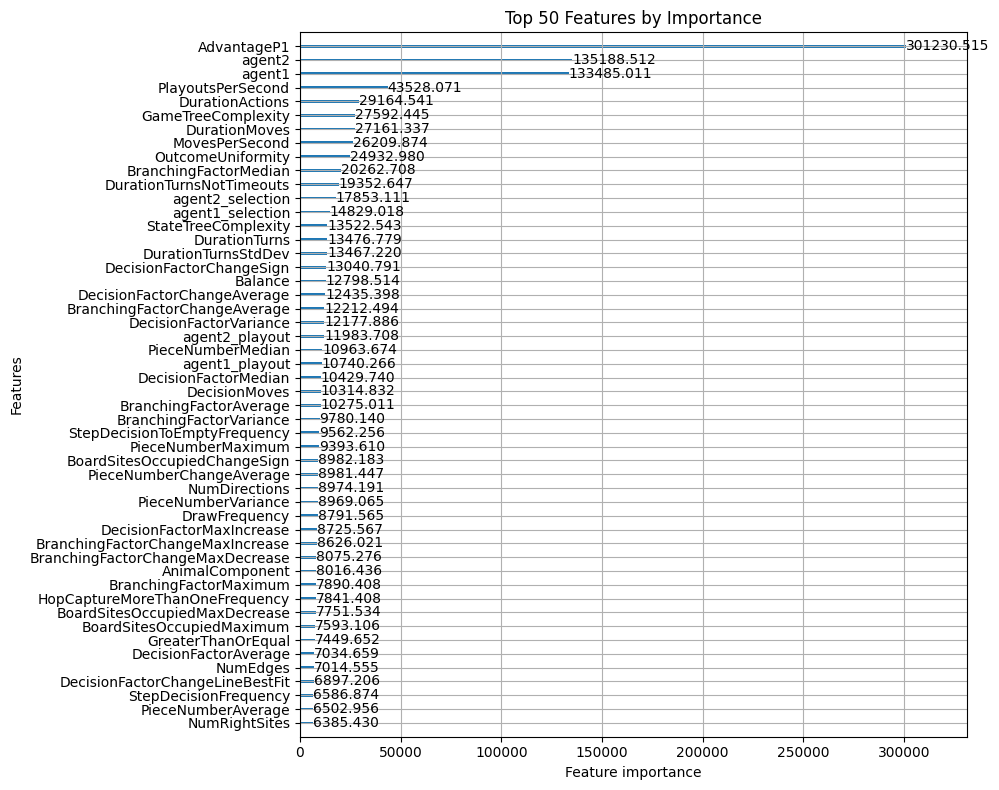

Fold 5 - RMSE: 0.40484212104722966
List of oof scores: [0.42568909751364725, 0.4477459367681129, 0.4341013770647174, 0.4354346027540548, 0.40484212104722966]
Average oof score: 0.4295626270295524


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.479926


[200]	valid_0's rmse: 0.460374


[300]	valid_0's rmse: 0.451412


[400]	valid_0's rmse: 0.445489


[500]	valid_0's rmse: 0.441648


[600]	valid_0's rmse: 0.438381


[700]	valid_0's rmse: 0.436218


[800]	valid_0's rmse: 0.434352


[900]	valid_0's rmse: 0.432884


[1000]	valid_0's rmse: 0.431545


[1100]	valid_0's rmse: 0.430267


[1200]	valid_0's rmse: 0.429452


[1300]	valid_0's rmse: 0.42883


[1400]	valid_0's rmse: 0.428065


[1500]	valid_0's rmse: 0.427566


[1600]	valid_0's rmse: 0.426774


[1700]	valid_0's rmse: 0.426233


[1800]	valid_0's rmse: 0.425664


[1900]	valid_0's rmse: 0.425032


[2000]	valid_0's rmse: 0.424549


[2100]	valid_0's rmse: 0.424139


[2200]	valid_0's rmse: 0.42375


[2300]	valid_0's rmse: 0.423493


[2400]	valid_0's rmse: 0.423217


[2500]	valid_0's rmse: 0.422778


[2600]	valid_0's rmse: 0.422405


[2700]	valid_0's rmse: 0.42222


[2800]	valid_0's rmse: 0.421965


[2900]	valid_0's rmse: 0.421691


[3000]	valid_0's rmse: 0.421441


[3100]	valid_0's rmse: 0.421235


[3200]	valid_0's rmse: 0.421071


[3300]	valid_0's rmse: 0.420834


[3400]	valid_0's rmse: 0.420597


[3500]	valid_0's rmse: 0.420446


[3600]	valid_0's rmse: 0.420296


[3700]	valid_0's rmse: 0.420035


[3800]	valid_0's rmse: 0.41978


[3900]	valid_0's rmse: 0.419597


[4000]	valid_0's rmse: 0.419261


[4100]	valid_0's rmse: 0.419078


[4200]	valid_0's rmse: 0.418983


[4300]	valid_0's rmse: 0.418852


[4400]	valid_0's rmse: 0.418695


[4500]	valid_0's rmse: 0.41863


[4600]	valid_0's rmse: 0.418522


[4700]	valid_0's rmse: 0.41844


[4800]	valid_0's rmse: 0.418373


[4900]	valid_0's rmse: 0.41819


[5000]	valid_0's rmse: 0.418119


[5100]	valid_0's rmse: 0.418046


[5200]	valid_0's rmse: 0.417875


[5300]	valid_0's rmse: 0.417806


[5400]	valid_0's rmse: 0.417722


[5500]	valid_0's rmse: 0.417698


[5600]	valid_0's rmse: 0.417596


[5700]	valid_0's rmse: 0.417478


[5800]	valid_0's rmse: 0.417433


[5900]	valid_0's rmse: 0.417374


[6000]	valid_0's rmse: 0.417295


[6100]	valid_0's rmse: 0.417254


[6200]	valid_0's rmse: 0.417222


[6300]	valid_0's rmse: 0.41714


[6400]	valid_0's rmse: 0.417137


[6500]	valid_0's rmse: 0.417083


[6600]	valid_0's rmse: 0.417053


[6700]	valid_0's rmse: 0.41712


[6800]	valid_0's rmse: 0.41709


[6900]	valid_0's rmse: 0.417077


[7000]	valid_0's rmse: 0.416995


[7100]	valid_0's rmse: 0.416941


[7200]	valid_0's rmse: 0.416969


[7300]	valid_0's rmse: 0.416959


[7400]	valid_0's rmse: 0.416867


[7500]	valid_0's rmse: 0.416867


[7600]	valid_0's rmse: 0.416827


[7700]	valid_0's rmse: 0.416804


[7800]	valid_0's rmse: 0.416758


[7900]	valid_0's rmse: 0.416674


[8000]	valid_0's rmse: 0.416659


[8100]	valid_0's rmse: 0.416644


[8200]	valid_0's rmse: 0.416599


[8300]	valid_0's rmse: 0.41652


[8400]	valid_0's rmse: 0.416459


[8500]	valid_0's rmse: 0.416354


[8600]	valid_0's rmse: 0.416348


[8700]	valid_0's rmse: 0.41627


[8800]	valid_0's rmse: 0.416186


[8900]	valid_0's rmse: 0.416096


[9000]	valid_0's rmse: 0.416111


[9100]	valid_0's rmse: 0.416143


[9200]	valid_0's rmse: 0.416169


[9300]	valid_0's rmse: 0.416084


[9400]	valid_0's rmse: 0.416094


[9500]	valid_0's rmse: 0.416029


[9600]	valid_0's rmse: 0.416053


[9700]	valid_0's rmse: 0.415997


[9800]	valid_0's rmse: 0.41597


[9900]	valid_0's rmse: 0.41596


[10000]	valid_0's rmse: 0.415866


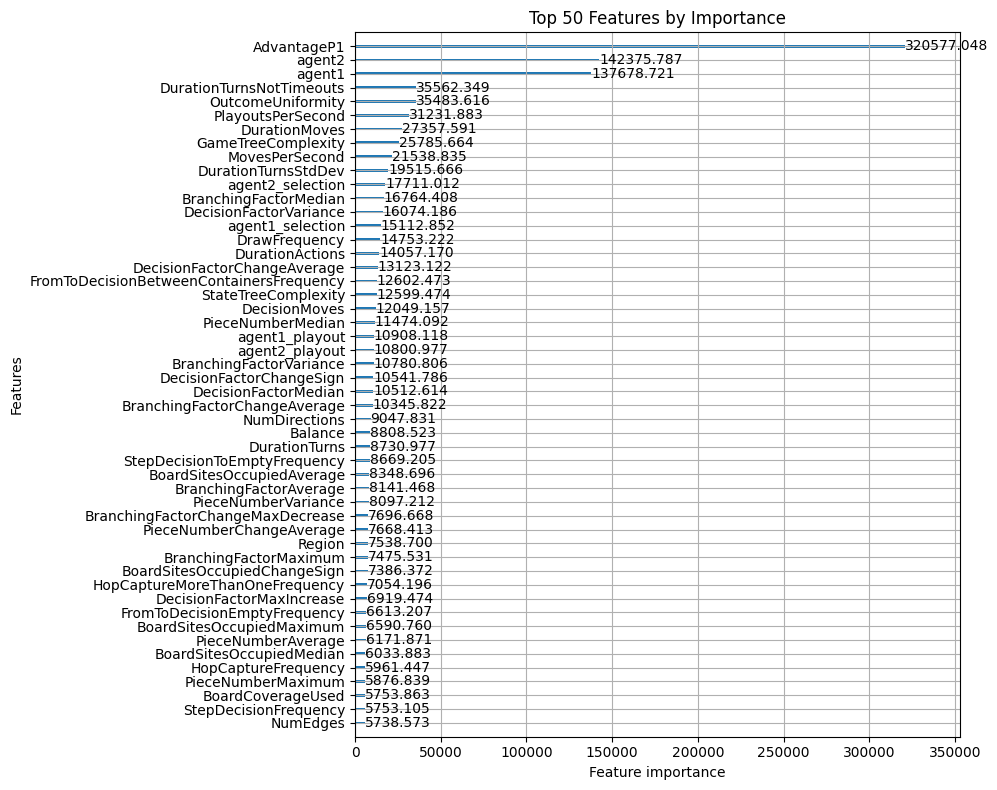

Fold 1 - RMSE: 0.4154222996575068
Fold 2


[100]	valid_0's rmse: 0.459527


[200]	valid_0's rmse: 0.438481


[300]	valid_0's rmse: 0.430177


[400]	valid_0's rmse: 0.424235


[500]	valid_0's rmse: 0.420988


[600]	valid_0's rmse: 0.41888


[700]	valid_0's rmse: 0.417059


[800]	valid_0's rmse: 0.415372


[900]	valid_0's rmse: 0.413807


[1000]	valid_0's rmse: 0.412496


[1100]	valid_0's rmse: 0.411535


[1200]	valid_0's rmse: 0.410678


[1300]	valid_0's rmse: 0.41013


[1400]	valid_0's rmse: 0.409536


[1500]	valid_0's rmse: 0.409031


[1600]	valid_0's rmse: 0.408666


[1700]	valid_0's rmse: 0.40823


[1800]	valid_0's rmse: 0.407906


[1900]	valid_0's rmse: 0.407405


[2000]	valid_0's rmse: 0.407044


[2100]	valid_0's rmse: 0.406815


[2200]	valid_0's rmse: 0.406573


[2300]	valid_0's rmse: 0.406307


[2400]	valid_0's rmse: 0.406047


[2500]	valid_0's rmse: 0.405711


[2600]	valid_0's rmse: 0.40541


[2700]	valid_0's rmse: 0.405298


[2800]	valid_0's rmse: 0.405073


[2900]	valid_0's rmse: 0.404991


[3000]	valid_0's rmse: 0.404747


[3100]	valid_0's rmse: 0.404613


[3200]	valid_0's rmse: 0.404536


[3300]	valid_0's rmse: 0.404355


[3400]	valid_0's rmse: 0.404321


[3500]	valid_0's rmse: 0.404242


[3600]	valid_0's rmse: 0.404168


[3700]	valid_0's rmse: 0.404112


[3800]	valid_0's rmse: 0.403981


[3900]	valid_0's rmse: 0.403943


[4000]	valid_0's rmse: 0.403847


[4100]	valid_0's rmse: 0.403752


[4200]	valid_0's rmse: 0.403683


[4300]	valid_0's rmse: 0.403657


[4400]	valid_0's rmse: 0.403626


[4500]	valid_0's rmse: 0.40361


[4600]	valid_0's rmse: 0.403526


[4700]	valid_0's rmse: 0.403458


[4800]	valid_0's rmse: 0.403397


[4900]	valid_0's rmse: 0.403296


[5000]	valid_0's rmse: 0.403221


[5100]	valid_0's rmse: 0.403146


[5200]	valid_0's rmse: 0.403109


[5300]	valid_0's rmse: 0.403071


[5400]	valid_0's rmse: 0.403054


[5500]	valid_0's rmse: 0.403009


[5600]	valid_0's rmse: 0.402957


[5700]	valid_0's rmse: 0.402913


[5800]	valid_0's rmse: 0.402858


[5900]	valid_0's rmse: 0.402788


[6000]	valid_0's rmse: 0.402771


[6100]	valid_0's rmse: 0.40277


[6200]	valid_0's rmse: 0.402778


[6300]	valid_0's rmse: 0.402731


[6400]	valid_0's rmse: 0.402657


[6500]	valid_0's rmse: 0.402684


[6600]	valid_0's rmse: 0.402619


[6700]	valid_0's rmse: 0.402568


[6800]	valid_0's rmse: 0.402565


[6900]	valid_0's rmse: 0.402547


[7000]	valid_0's rmse: 0.402544


[7100]	valid_0's rmse: 0.40256


[7200]	valid_0's rmse: 0.402481


[7300]	valid_0's rmse: 0.402466


[7400]	valid_0's rmse: 0.402492


[7500]	valid_0's rmse: 0.402516


[7600]	valid_0's rmse: 0.402569


[7700]	valid_0's rmse: 0.402564


[7800]	valid_0's rmse: 0.402504


[7900]	valid_0's rmse: 0.402536


[8000]	valid_0's rmse: 0.402517


[8100]	valid_0's rmse: 0.402491


[8200]	valid_0's rmse: 0.40251


[8300]	valid_0's rmse: 0.402571


[8400]	valid_0's rmse: 0.402587


[8500]	valid_0's rmse: 0.402554


[8600]	valid_0's rmse: 0.402558


[8700]	valid_0's rmse: 0.402529


[8800]	valid_0's rmse: 0.402557


[8900]	valid_0's rmse: 0.402565


[9000]	valid_0's rmse: 0.402619


[9100]	valid_0's rmse: 0.402624


[9200]	valid_0's rmse: 0.402626


[9300]	valid_0's rmse: 0.402597


[9400]	valid_0's rmse: 0.402562


[9500]	valid_0's rmse: 0.402544


[9600]	valid_0's rmse: 0.402567


[9700]	valid_0's rmse: 0.402615


[9800]	valid_0's rmse: 0.402577


[9900]	valid_0's rmse: 0.402632


[10000]	valid_0's rmse: 0.402659


Fold 2 - RMSE: 0.4017827870011364
Fold 3


[100]	valid_0's rmse: 0.524712


[200]	valid_0's rmse: 0.498492


[300]	valid_0's rmse: 0.484553


[400]	valid_0's rmse: 0.475099


[500]	valid_0's rmse: 0.469681


[600]	valid_0's rmse: 0.464719


[700]	valid_0's rmse: 0.460955


[800]	valid_0's rmse: 0.458091


[900]	valid_0's rmse: 0.455904


[1000]	valid_0's rmse: 0.4537


[1100]	valid_0's rmse: 0.451947


[1200]	valid_0's rmse: 0.450389


[1300]	valid_0's rmse: 0.449292


[1400]	valid_0's rmse: 0.448304


[1500]	valid_0's rmse: 0.447518


[1600]	valid_0's rmse: 0.446711


[1700]	valid_0's rmse: 0.445883


[1800]	valid_0's rmse: 0.445089


[1900]	valid_0's rmse: 0.444497


[2000]	valid_0's rmse: 0.443976


[2100]	valid_0's rmse: 0.443495


[2200]	valid_0's rmse: 0.442818


[2300]	valid_0's rmse: 0.442304


[2400]	valid_0's rmse: 0.44191


[2500]	valid_0's rmse: 0.441527


[2600]	valid_0's rmse: 0.441129


[2700]	valid_0's rmse: 0.440662


[2800]	valid_0's rmse: 0.440372


[2900]	valid_0's rmse: 0.439958


[3000]	valid_0's rmse: 0.439651


[3100]	valid_0's rmse: 0.439342


[3200]	valid_0's rmse: 0.439166


[3300]	valid_0's rmse: 0.438908


[3400]	valid_0's rmse: 0.43861


[3500]	valid_0's rmse: 0.438358


[3600]	valid_0's rmse: 0.438082


[3700]	valid_0's rmse: 0.43795


[3800]	valid_0's rmse: 0.43778


[3900]	valid_0's rmse: 0.437563


[4000]	valid_0's rmse: 0.437263


[4100]	valid_0's rmse: 0.437095


[4200]	valid_0's rmse: 0.436922


[4300]	valid_0's rmse: 0.436714


[4400]	valid_0's rmse: 0.4366


[4500]	valid_0's rmse: 0.436454


[4600]	valid_0's rmse: 0.436273


[4700]	valid_0's rmse: 0.436111


[4800]	valid_0's rmse: 0.436032


[4900]	valid_0's rmse: 0.435983


[5000]	valid_0's rmse: 0.435835


[5100]	valid_0's rmse: 0.435659


[5200]	valid_0's rmse: 0.43567


[5300]	valid_0's rmse: 0.435531


[5400]	valid_0's rmse: 0.435308


[5500]	valid_0's rmse: 0.435125


[5600]	valid_0's rmse: 0.435077


[5700]	valid_0's rmse: 0.434964


[5800]	valid_0's rmse: 0.434817


[5900]	valid_0's rmse: 0.434736


[6000]	valid_0's rmse: 0.434715


[6100]	valid_0's rmse: 0.434608


[6200]	valid_0's rmse: 0.434529


[6300]	valid_0's rmse: 0.434504


[6400]	valid_0's rmse: 0.434479


[6500]	valid_0's rmse: 0.43444


[6600]	valid_0's rmse: 0.434299


[6700]	valid_0's rmse: 0.43421


[6800]	valid_0's rmse: 0.434175


[6900]	valid_0's rmse: 0.434136


[7000]	valid_0's rmse: 0.43406


[7100]	valid_0's rmse: 0.433999


[7200]	valid_0's rmse: 0.43394


[7300]	valid_0's rmse: 0.433919


[7400]	valid_0's rmse: 0.433922


[7500]	valid_0's rmse: 0.433882


[7600]	valid_0's rmse: 0.433814


[7700]	valid_0's rmse: 0.433798


[7800]	valid_0's rmse: 0.433773


[7900]	valid_0's rmse: 0.433748


[8000]	valid_0's rmse: 0.433669


[8100]	valid_0's rmse: 0.433596


[8200]	valid_0's rmse: 0.433592


[8300]	valid_0's rmse: 0.433506


[8400]	valid_0's rmse: 0.433469


[8500]	valid_0's rmse: 0.433385


[8600]	valid_0's rmse: 0.433341


[8700]	valid_0's rmse: 0.433298


[8800]	valid_0's rmse: 0.433274


[8900]	valid_0's rmse: 0.433257


[9000]	valid_0's rmse: 0.433231


[9100]	valid_0's rmse: 0.433191


[9200]	valid_0's rmse: 0.433275


[9300]	valid_0's rmse: 0.433151


[9400]	valid_0's rmse: 0.433104


[9500]	valid_0's rmse: 0.433069


[9600]	valid_0's rmse: 0.433067


[9700]	valid_0's rmse: 0.433027


[9800]	valid_0's rmse: 0.433009


[9900]	valid_0's rmse: 0.432968


[10000]	valid_0's rmse: 0.432905


Fold 3 - RMSE: 0.4321983097872131
Fold 4


[100]	valid_0's rmse: 0.523129


[200]	valid_0's rmse: 0.495727


[300]	valid_0's rmse: 0.482496


[400]	valid_0's rmse: 0.472766


[500]	valid_0's rmse: 0.467276


[600]	valid_0's rmse: 0.463599


[700]	valid_0's rmse: 0.460381


[800]	valid_0's rmse: 0.457666


[900]	valid_0's rmse: 0.45546


[1000]	valid_0's rmse: 0.45369


[1100]	valid_0's rmse: 0.452292


[1200]	valid_0's rmse: 0.451209


[1300]	valid_0's rmse: 0.450155


[1400]	valid_0's rmse: 0.449139


[1500]	valid_0's rmse: 0.448437


[1600]	valid_0's rmse: 0.447514


[1700]	valid_0's rmse: 0.44691


[1800]	valid_0's rmse: 0.44643


[1900]	valid_0's rmse: 0.446081


[2000]	valid_0's rmse: 0.445495


[2100]	valid_0's rmse: 0.445091


[2200]	valid_0's rmse: 0.44457


[2300]	valid_0's rmse: 0.444163


[2400]	valid_0's rmse: 0.443898


[2500]	valid_0's rmse: 0.443568


[2600]	valid_0's rmse: 0.443282


[2700]	valid_0's rmse: 0.442955


[2800]	valid_0's rmse: 0.442698


[2900]	valid_0's rmse: 0.442512


[3000]	valid_0's rmse: 0.442314


[3100]	valid_0's rmse: 0.442099


[3200]	valid_0's rmse: 0.4419


[3300]	valid_0's rmse: 0.441689


[3400]	valid_0's rmse: 0.441433


[3500]	valid_0's rmse: 0.441272


[3600]	valid_0's rmse: 0.441211


[3700]	valid_0's rmse: 0.441005


[3800]	valid_0's rmse: 0.440776


[3900]	valid_0's rmse: 0.44061


[4000]	valid_0's rmse: 0.440439


[4100]	valid_0's rmse: 0.440316


[4200]	valid_0's rmse: 0.440116


[4300]	valid_0's rmse: 0.43993


[4400]	valid_0's rmse: 0.439927


[4500]	valid_0's rmse: 0.439809


[4600]	valid_0's rmse: 0.439661


[4700]	valid_0's rmse: 0.439562


[4800]	valid_0's rmse: 0.439493


[4900]	valid_0's rmse: 0.439411


[5000]	valid_0's rmse: 0.439333


[5100]	valid_0's rmse: 0.43916


[5200]	valid_0's rmse: 0.438993


[5300]	valid_0's rmse: 0.438938


[5400]	valid_0's rmse: 0.438816


[5500]	valid_0's rmse: 0.438708


[5600]	valid_0's rmse: 0.438659


[5700]	valid_0's rmse: 0.43852


[5800]	valid_0's rmse: 0.438484


[5900]	valid_0's rmse: 0.438491


[6000]	valid_0's rmse: 0.43845


[6100]	valid_0's rmse: 0.438436


[6200]	valid_0's rmse: 0.438293


[6300]	valid_0's rmse: 0.438221


[6400]	valid_0's rmse: 0.438052


[6500]	valid_0's rmse: 0.437982


[6600]	valid_0's rmse: 0.437921


[6700]	valid_0's rmse: 0.437753


[6800]	valid_0's rmse: 0.437716


[6900]	valid_0's rmse: 0.437669


[7000]	valid_0's rmse: 0.437633


[7100]	valid_0's rmse: 0.437565


[7200]	valid_0's rmse: 0.437613


[7300]	valid_0's rmse: 0.437662


[7400]	valid_0's rmse: 0.437681


[7500]	valid_0's rmse: 0.437627


[7600]	valid_0's rmse: 0.437543


[7700]	valid_0's rmse: 0.437511


[7800]	valid_0's rmse: 0.437475


[7900]	valid_0's rmse: 0.437459


[8000]	valid_0's rmse: 0.437456


[8100]	valid_0's rmse: 0.437314


[8200]	valid_0's rmse: 0.437285


[8300]	valid_0's rmse: 0.437242


[8400]	valid_0's rmse: 0.437288


[8500]	valid_0's rmse: 0.437265


[8600]	valid_0's rmse: 0.437318


[8700]	valid_0's rmse: 0.437315


[8800]	valid_0's rmse: 0.437261


[8900]	valid_0's rmse: 0.437251


[9000]	valid_0's rmse: 0.43718


[9100]	valid_0's rmse: 0.437175


[9200]	valid_0's rmse: 0.437082


[9300]	valid_0's rmse: 0.437081


[9400]	valid_0's rmse: 0.437036


[9500]	valid_0's rmse: 0.437017


[9600]	valid_0's rmse: 0.43704


[9700]	valid_0's rmse: 0.437004


[9800]	valid_0's rmse: 0.437023


[9900]	valid_0's rmse: 0.436933


[10000]	valid_0's rmse: 0.436897


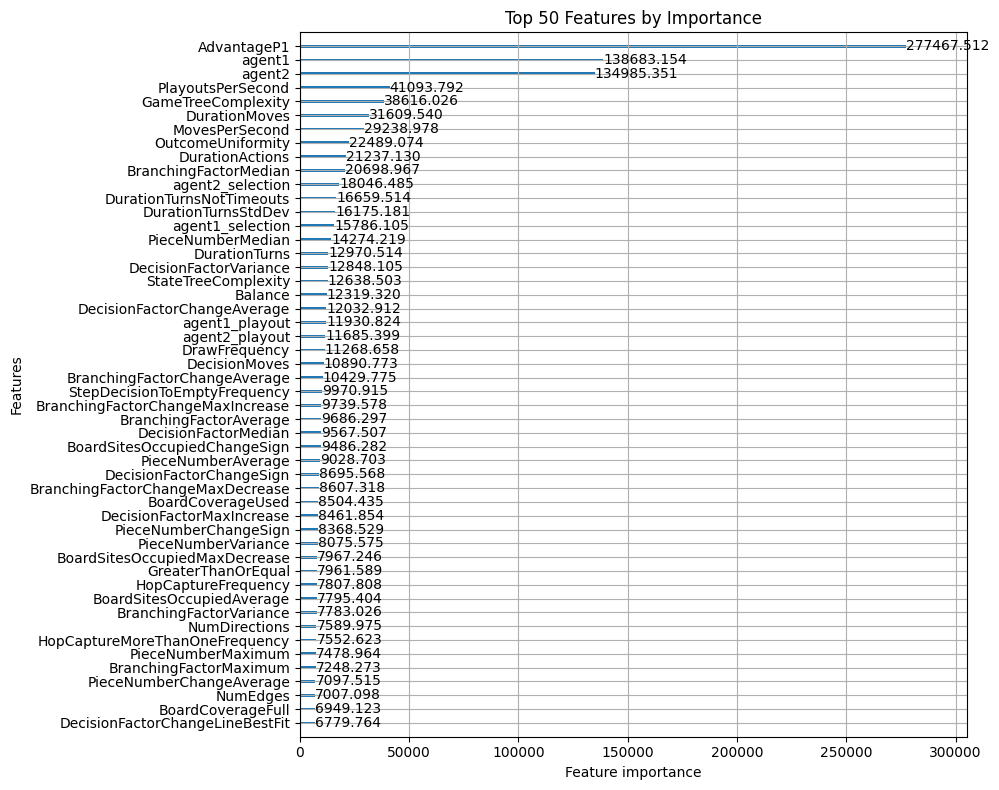

Fold 4 - RMSE: 0.4365527493488938
Fold 5


[100]	valid_0's rmse: 0.51659


[200]	valid_0's rmse: 0.492258


[300]	valid_0's rmse: 0.478575


[400]	valid_0's rmse: 0.469791


[500]	valid_0's rmse: 0.463981


[600]	valid_0's rmse: 0.458965


[700]	valid_0's rmse: 0.455388


[800]	valid_0's rmse: 0.452053


[900]	valid_0's rmse: 0.449356


[1000]	valid_0's rmse: 0.446974


[1100]	valid_0's rmse: 0.445254


[1200]	valid_0's rmse: 0.443676


[1300]	valid_0's rmse: 0.442303


[1400]	valid_0's rmse: 0.441022


[1500]	valid_0's rmse: 0.440113


[1600]	valid_0's rmse: 0.439354


[1700]	valid_0's rmse: 0.438512


[1800]	valid_0's rmse: 0.437656


[1900]	valid_0's rmse: 0.43694


[2000]	valid_0's rmse: 0.43635


[2100]	valid_0's rmse: 0.435707


[2200]	valid_0's rmse: 0.435031


[2300]	valid_0's rmse: 0.434468


[2400]	valid_0's rmse: 0.433949


[2500]	valid_0's rmse: 0.433542


[2600]	valid_0's rmse: 0.43303


[2700]	valid_0's rmse: 0.432511


[2800]	valid_0's rmse: 0.432339


[2900]	valid_0's rmse: 0.432028


[3000]	valid_0's rmse: 0.431768


[3100]	valid_0's rmse: 0.431503


[3200]	valid_0's rmse: 0.431295


[3300]	valid_0's rmse: 0.43103


[3400]	valid_0's rmse: 0.430778


[3500]	valid_0's rmse: 0.430448


[3600]	valid_0's rmse: 0.43019


[3700]	valid_0's rmse: 0.42996


[3800]	valid_0's rmse: 0.429711


[3900]	valid_0's rmse: 0.429554


[4000]	valid_0's rmse: 0.429432


[4100]	valid_0's rmse: 0.429277


[4200]	valid_0's rmse: 0.429115


[4300]	valid_0's rmse: 0.429058


[4400]	valid_0's rmse: 0.428849


[4500]	valid_0's rmse: 0.428706


[4600]	valid_0's rmse: 0.428531


[4700]	valid_0's rmse: 0.428367


[4800]	valid_0's rmse: 0.428271


[4900]	valid_0's rmse: 0.428193


[5000]	valid_0's rmse: 0.428005


[5100]	valid_0's rmse: 0.427867


[5200]	valid_0's rmse: 0.427661


[5300]	valid_0's rmse: 0.427557


[5400]	valid_0's rmse: 0.427454


[5500]	valid_0's rmse: 0.427377


[5600]	valid_0's rmse: 0.42723


[5700]	valid_0's rmse: 0.42708


[5800]	valid_0's rmse: 0.427037


[5900]	valid_0's rmse: 0.426946


[6000]	valid_0's rmse: 0.426867


[6100]	valid_0's rmse: 0.426833


[6200]	valid_0's rmse: 0.426768


[6300]	valid_0's rmse: 0.426673


[6400]	valid_0's rmse: 0.426619


[6500]	valid_0's rmse: 0.426546


[6600]	valid_0's rmse: 0.426557


[6700]	valid_0's rmse: 0.426496


[6800]	valid_0's rmse: 0.426411


[6900]	valid_0's rmse: 0.426352


[7000]	valid_0's rmse: 0.426249


[7100]	valid_0's rmse: 0.426206


[7200]	valid_0's rmse: 0.42611


[7300]	valid_0's rmse: 0.426026


[7400]	valid_0's rmse: 0.425961


[7500]	valid_0's rmse: 0.425993


[7600]	valid_0's rmse: 0.425988


[7700]	valid_0's rmse: 0.425942


[7800]	valid_0's rmse: 0.425842


[7900]	valid_0's rmse: 0.425756


[8000]	valid_0's rmse: 0.425735


[8100]	valid_0's rmse: 0.425676


[8200]	valid_0's rmse: 0.425683


[8300]	valid_0's rmse: 0.42565


[8400]	valid_0's rmse: 0.425616


[8500]	valid_0's rmse: 0.425503


[8600]	valid_0's rmse: 0.425469


[8700]	valid_0's rmse: 0.425462


[8800]	valid_0's rmse: 0.425453


[8900]	valid_0's rmse: 0.425428


[9000]	valid_0's rmse: 0.425333


[9100]	valid_0's rmse: 0.425338


[9200]	valid_0's rmse: 0.425265


[9300]	valid_0's rmse: 0.42518


[9400]	valid_0's rmse: 0.425165


[9500]	valid_0's rmse: 0.425149


[9600]	valid_0's rmse: 0.425097


[9700]	valid_0's rmse: 0.425048


[9800]	valid_0's rmse: 0.425042


[9900]	valid_0's rmse: 0.425023


[10000]	valid_0's rmse: 0.425001


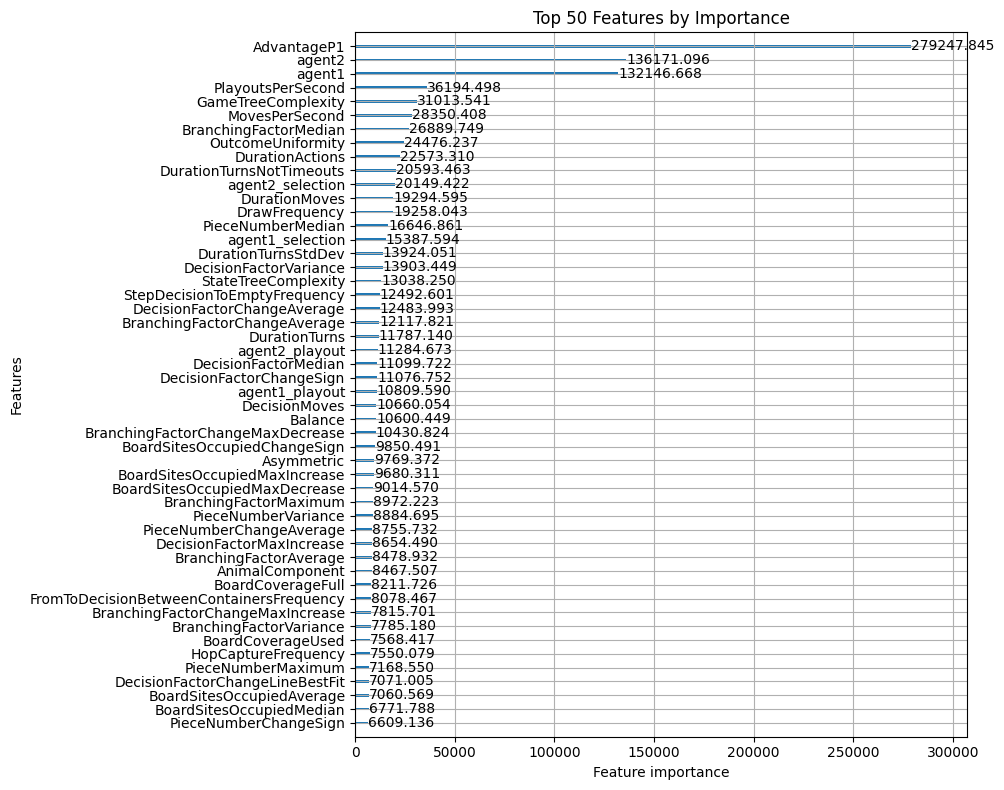

Fold 5 - RMSE: 0.4243613153845
List of oof scores: [0.4154222996575068, 0.4017827870011364, 0.4321983097872131, 0.4365527493488938, 0.4243613153845]
Average oof score: 0.42206349223585005


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.50487


[200]	valid_0's rmse: 0.481871


[300]	valid_0's rmse: 0.470423


[400]	valid_0's rmse: 0.463821


[500]	valid_0's rmse: 0.458954


[600]	valid_0's rmse: 0.454979


[700]	valid_0's rmse: 0.45197


[800]	valid_0's rmse: 0.449354


[900]	valid_0's rmse: 0.447599


[1000]	valid_0's rmse: 0.446019


[1100]	valid_0's rmse: 0.444855


[1200]	valid_0's rmse: 0.443688


[1300]	valid_0's rmse: 0.442836


[1400]	valid_0's rmse: 0.442034


[1500]	valid_0's rmse: 0.441279


[1600]	valid_0's rmse: 0.440464


[1700]	valid_0's rmse: 0.439754


[1800]	valid_0's rmse: 0.439092


[1900]	valid_0's rmse: 0.438598


[2000]	valid_0's rmse: 0.438223


[2100]	valid_0's rmse: 0.437896


[2200]	valid_0's rmse: 0.437589


[2300]	valid_0's rmse: 0.437162


[2400]	valid_0's rmse: 0.436842


[2500]	valid_0's rmse: 0.436493


[2600]	valid_0's rmse: 0.436219


[2700]	valid_0's rmse: 0.435956


[2800]	valid_0's rmse: 0.435758


[2900]	valid_0's rmse: 0.43562


[3000]	valid_0's rmse: 0.435406


[3100]	valid_0's rmse: 0.435267


[3200]	valid_0's rmse: 0.435061


[3300]	valid_0's rmse: 0.434942


[3400]	valid_0's rmse: 0.434651


[3500]	valid_0's rmse: 0.434401


[3600]	valid_0's rmse: 0.434228


[3700]	valid_0's rmse: 0.43414


[3800]	valid_0's rmse: 0.433914


[3900]	valid_0's rmse: 0.43378


[4000]	valid_0's rmse: 0.433593


[4100]	valid_0's rmse: 0.433483


[4200]	valid_0's rmse: 0.433405


[4300]	valid_0's rmse: 0.433227


[4400]	valid_0's rmse: 0.433082


[4500]	valid_0's rmse: 0.432916


[4600]	valid_0's rmse: 0.432726


[4700]	valid_0's rmse: 0.432626


[4800]	valid_0's rmse: 0.432452


[4900]	valid_0's rmse: 0.432384


[5000]	valid_0's rmse: 0.432344


[5100]	valid_0's rmse: 0.432296


[5200]	valid_0's rmse: 0.43217


[5300]	valid_0's rmse: 0.432047


[5400]	valid_0's rmse: 0.431921


[5500]	valid_0's rmse: 0.431832


[5600]	valid_0's rmse: 0.431712


[5700]	valid_0's rmse: 0.431669


[5800]	valid_0's rmse: 0.431562


[5900]	valid_0's rmse: 0.431553


[6000]	valid_0's rmse: 0.431524


[6100]	valid_0's rmse: 0.431485


[6200]	valid_0's rmse: 0.431408


[6300]	valid_0's rmse: 0.431316


[6400]	valid_0's rmse: 0.431276


[6500]	valid_0's rmse: 0.431231


[6600]	valid_0's rmse: 0.431234


[6700]	valid_0's rmse: 0.431192


[6800]	valid_0's rmse: 0.431138


[6900]	valid_0's rmse: 0.431094


[7000]	valid_0's rmse: 0.431023


[7100]	valid_0's rmse: 0.43099


[7200]	valid_0's rmse: 0.430957


[7300]	valid_0's rmse: 0.430924


[7400]	valid_0's rmse: 0.430861


[7500]	valid_0's rmse: 0.430808


[7600]	valid_0's rmse: 0.430808


[7700]	valid_0's rmse: 0.4307


[7800]	valid_0's rmse: 0.430631


[7900]	valid_0's rmse: 0.430576


[8000]	valid_0's rmse: 0.430482


[8100]	valid_0's rmse: 0.430514


[8200]	valid_0's rmse: 0.43042


[8300]	valid_0's rmse: 0.430402


[8400]	valid_0's rmse: 0.430371


[8500]	valid_0's rmse: 0.430328


[8600]	valid_0's rmse: 0.430238


[8700]	valid_0's rmse: 0.430268


[8800]	valid_0's rmse: 0.430268


[8900]	valid_0's rmse: 0.430236


[9000]	valid_0's rmse: 0.430207


[9100]	valid_0's rmse: 0.430216


[9200]	valid_0's rmse: 0.430224


[9300]	valid_0's rmse: 0.430209


[9400]	valid_0's rmse: 0.430234


[9500]	valid_0's rmse: 0.430237


[9600]	valid_0's rmse: 0.430254


[9700]	valid_0's rmse: 0.430204


[9800]	valid_0's rmse: 0.430213


[9900]	valid_0's rmse: 0.430199


[10000]	valid_0's rmse: 0.430214


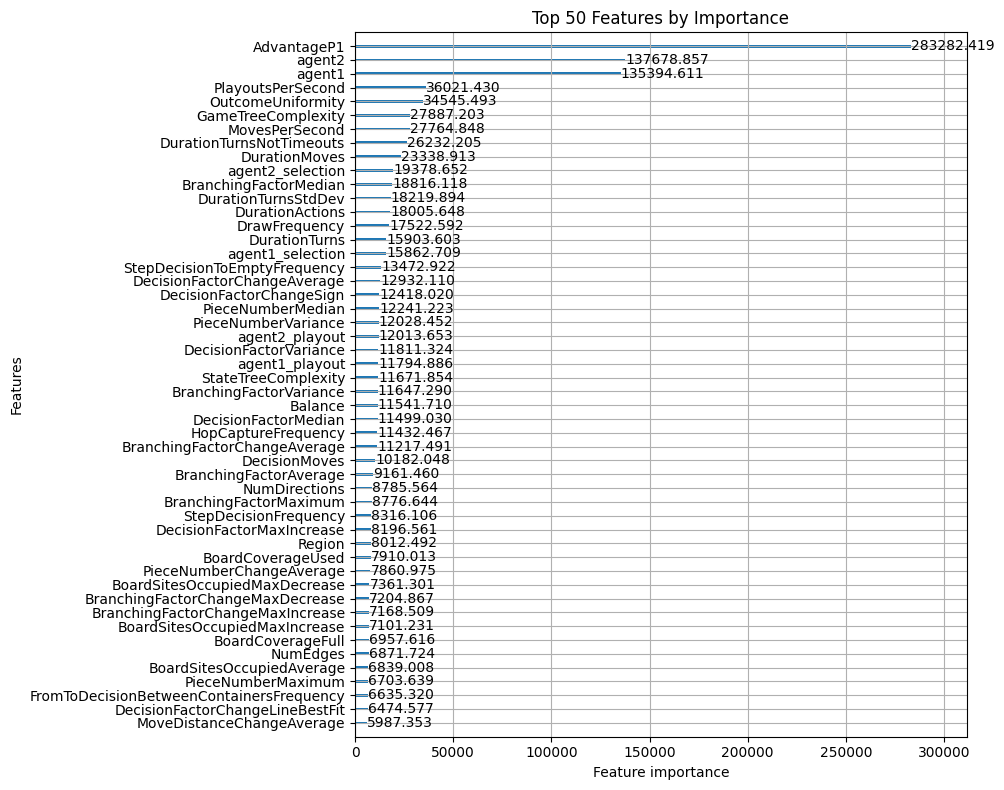

Fold 1 - RMSE: 0.42967570203589445
Fold 2


[100]	valid_0's rmse: 0.506249


[200]	valid_0's rmse: 0.483597


[300]	valid_0's rmse: 0.468799


[400]	valid_0's rmse: 0.460265


[500]	valid_0's rmse: 0.45413


[600]	valid_0's rmse: 0.449452


[700]	valid_0's rmse: 0.445606


[800]	valid_0's rmse: 0.443206


[900]	valid_0's rmse: 0.440717


[1000]	valid_0's rmse: 0.43879


[1100]	valid_0's rmse: 0.436886


[1200]	valid_0's rmse: 0.435135


[1300]	valid_0's rmse: 0.4337


[1400]	valid_0's rmse: 0.432232


[1500]	valid_0's rmse: 0.431289


[1600]	valid_0's rmse: 0.430418


[1700]	valid_0's rmse: 0.429843


[1800]	valid_0's rmse: 0.429115


[1900]	valid_0's rmse: 0.428573


[2000]	valid_0's rmse: 0.427988


[2100]	valid_0's rmse: 0.427443


[2200]	valid_0's rmse: 0.42688


[2300]	valid_0's rmse: 0.426368


[2400]	valid_0's rmse: 0.425938


[2500]	valid_0's rmse: 0.425555


[2600]	valid_0's rmse: 0.425126


[2700]	valid_0's rmse: 0.42481


[2800]	valid_0's rmse: 0.424516


[2900]	valid_0's rmse: 0.424211


[3000]	valid_0's rmse: 0.423961


[3100]	valid_0's rmse: 0.4236


[3200]	valid_0's rmse: 0.423269


[3300]	valid_0's rmse: 0.422994


[3400]	valid_0's rmse: 0.422642


[3500]	valid_0's rmse: 0.422438


[3600]	valid_0's rmse: 0.422214


[3700]	valid_0's rmse: 0.421997


[3800]	valid_0's rmse: 0.421723


[3900]	valid_0's rmse: 0.42154


[4000]	valid_0's rmse: 0.421333


[4100]	valid_0's rmse: 0.421081


[4200]	valid_0's rmse: 0.420832


[4300]	valid_0's rmse: 0.42064


[4400]	valid_0's rmse: 0.420455


[4500]	valid_0's rmse: 0.420235


[4600]	valid_0's rmse: 0.420113


[4700]	valid_0's rmse: 0.419869


[4800]	valid_0's rmse: 0.419727


[4900]	valid_0's rmse: 0.419573


[5000]	valid_0's rmse: 0.419431


[5100]	valid_0's rmse: 0.419299


[5200]	valid_0's rmse: 0.41922


[5300]	valid_0's rmse: 0.419063


[5400]	valid_0's rmse: 0.419059


[5500]	valid_0's rmse: 0.418939


[5600]	valid_0's rmse: 0.418809


[5700]	valid_0's rmse: 0.418726


[5800]	valid_0's rmse: 0.41866


[5900]	valid_0's rmse: 0.418534


[6000]	valid_0's rmse: 0.418487


[6100]	valid_0's rmse: 0.418436


[6200]	valid_0's rmse: 0.418391


[6300]	valid_0's rmse: 0.418267


[6400]	valid_0's rmse: 0.418216


[6500]	valid_0's rmse: 0.418164


[6600]	valid_0's rmse: 0.418058


[6700]	valid_0's rmse: 0.418028


[6800]	valid_0's rmse: 0.417925


[6900]	valid_0's rmse: 0.41791


[7000]	valid_0's rmse: 0.417818


[7100]	valid_0's rmse: 0.417779


[7200]	valid_0's rmse: 0.41769


[7300]	valid_0's rmse: 0.417603


[7400]	valid_0's rmse: 0.417499


[7500]	valid_0's rmse: 0.417484


[7600]	valid_0's rmse: 0.417499


[7700]	valid_0's rmse: 0.417525


[7800]	valid_0's rmse: 0.417514


[7900]	valid_0's rmse: 0.417491


[8000]	valid_0's rmse: 0.417409


[8100]	valid_0's rmse: 0.41742


[8200]	valid_0's rmse: 0.417308


[8300]	valid_0's rmse: 0.417265


[8400]	valid_0's rmse: 0.417216


[8500]	valid_0's rmse: 0.417217


[8600]	valid_0's rmse: 0.417181


[8700]	valid_0's rmse: 0.417213


[8800]	valid_0's rmse: 0.417153


[8900]	valid_0's rmse: 0.417064


[9000]	valid_0's rmse: 0.417011


[9100]	valid_0's rmse: 0.416957


[9200]	valid_0's rmse: 0.416897


[9300]	valid_0's rmse: 0.416896


[9400]	valid_0's rmse: 0.416953


[9500]	valid_0's rmse: 0.416946


[9600]	valid_0's rmse: 0.416883


[9700]	valid_0's rmse: 0.416871


[9800]	valid_0's rmse: 0.416814


[9900]	valid_0's rmse: 0.416743


[10000]	valid_0's rmse: 0.416658


Fold 2 - RMSE: 0.4161412328704214
Fold 3


[100]	valid_0's rmse: 0.495591


[200]	valid_0's rmse: 0.471965


[300]	valid_0's rmse: 0.460105


[400]	valid_0's rmse: 0.452639


[500]	valid_0's rmse: 0.448265


[600]	valid_0's rmse: 0.445295


[700]	valid_0's rmse: 0.442688


[800]	valid_0's rmse: 0.440347


[900]	valid_0's rmse: 0.438404


[1000]	valid_0's rmse: 0.436851


[1100]	valid_0's rmse: 0.435584


[1200]	valid_0's rmse: 0.43443


[1300]	valid_0's rmse: 0.433207


[1400]	valid_0's rmse: 0.432108


[1500]	valid_0's rmse: 0.431335


[1600]	valid_0's rmse: 0.430834


[1700]	valid_0's rmse: 0.430247


[1800]	valid_0's rmse: 0.429716


[1900]	valid_0's rmse: 0.429363


[2000]	valid_0's rmse: 0.429018


[2100]	valid_0's rmse: 0.428582


[2200]	valid_0's rmse: 0.428053


[2300]	valid_0's rmse: 0.42753


[2400]	valid_0's rmse: 0.427149


[2500]	valid_0's rmse: 0.426911


[2600]	valid_0's rmse: 0.42661


[2700]	valid_0's rmse: 0.426241


[2800]	valid_0's rmse: 0.426028


[2900]	valid_0's rmse: 0.425822


[3000]	valid_0's rmse: 0.425539


[3100]	valid_0's rmse: 0.425359


[3200]	valid_0's rmse: 0.425182


[3300]	valid_0's rmse: 0.425069


[3400]	valid_0's rmse: 0.424891


[3500]	valid_0's rmse: 0.42469


[3600]	valid_0's rmse: 0.424542


[3700]	valid_0's rmse: 0.424387


[3800]	valid_0's rmse: 0.424223


[3900]	valid_0's rmse: 0.424014


[4000]	valid_0's rmse: 0.423898


[4100]	valid_0's rmse: 0.423809


[4200]	valid_0's rmse: 0.42367


[4300]	valid_0's rmse: 0.423488


[4400]	valid_0's rmse: 0.423408


[4500]	valid_0's rmse: 0.423283


[4600]	valid_0's rmse: 0.423203


[4700]	valid_0's rmse: 0.42312


[4800]	valid_0's rmse: 0.42299


[4900]	valid_0's rmse: 0.422893


[5000]	valid_0's rmse: 0.422815


[5100]	valid_0's rmse: 0.422753


[5200]	valid_0's rmse: 0.422595


[5300]	valid_0's rmse: 0.422552


[5400]	valid_0's rmse: 0.422431


[5500]	valid_0's rmse: 0.422302


[5600]	valid_0's rmse: 0.422255


[5700]	valid_0's rmse: 0.422212


[5800]	valid_0's rmse: 0.422157


[5900]	valid_0's rmse: 0.422106


[6000]	valid_0's rmse: 0.422142


[6100]	valid_0's rmse: 0.42204


[6200]	valid_0's rmse: 0.422037


[6300]	valid_0's rmse: 0.42204


[6400]	valid_0's rmse: 0.421967


[6500]	valid_0's rmse: 0.421892


[6600]	valid_0's rmse: 0.421829


[6700]	valid_0's rmse: 0.421766


[6800]	valid_0's rmse: 0.421707


[6900]	valid_0's rmse: 0.421672


[7000]	valid_0's rmse: 0.421655


[7100]	valid_0's rmse: 0.42159


[7200]	valid_0's rmse: 0.421524


[7300]	valid_0's rmse: 0.421528


[7400]	valid_0's rmse: 0.421505


[7500]	valid_0's rmse: 0.421446


[7600]	valid_0's rmse: 0.42137


[7700]	valid_0's rmse: 0.421346


[7800]	valid_0's rmse: 0.421264


[7900]	valid_0's rmse: 0.421256


[8000]	valid_0's rmse: 0.421216


[8100]	valid_0's rmse: 0.421223


[8200]	valid_0's rmse: 0.421183


[8300]	valid_0's rmse: 0.421171


[8400]	valid_0's rmse: 0.421109


[8500]	valid_0's rmse: 0.421073


[8600]	valid_0's rmse: 0.421057


[8700]	valid_0's rmse: 0.421049


[8800]	valid_0's rmse: 0.421014


[8900]	valid_0's rmse: 0.421025


[9000]	valid_0's rmse: 0.420984


[9100]	valid_0's rmse: 0.420956


[9200]	valid_0's rmse: 0.420923


[9300]	valid_0's rmse: 0.420891


[9400]	valid_0's rmse: 0.420833


[9500]	valid_0's rmse: 0.420776


[9600]	valid_0's rmse: 0.420803


[9700]	valid_0's rmse: 0.420797


[9800]	valid_0's rmse: 0.420821


[9900]	valid_0's rmse: 0.420788


[10000]	valid_0's rmse: 0.420793


Fold 3 - RMSE: 0.42033993795942926
Fold 4


[100]	valid_0's rmse: 0.484368


[200]	valid_0's rmse: 0.462828


[300]	valid_0's rmse: 0.453758


[400]	valid_0's rmse: 0.44724


[500]	valid_0's rmse: 0.442534


[600]	valid_0's rmse: 0.438416


[700]	valid_0's rmse: 0.435408


[800]	valid_0's rmse: 0.432877


[900]	valid_0's rmse: 0.431118


[1000]	valid_0's rmse: 0.429473


[1100]	valid_0's rmse: 0.428003


[1200]	valid_0's rmse: 0.426867


[1300]	valid_0's rmse: 0.425904


[1400]	valid_0's rmse: 0.425244


[1500]	valid_0's rmse: 0.424463


[1600]	valid_0's rmse: 0.423955


[1700]	valid_0's rmse: 0.42328


[1800]	valid_0's rmse: 0.422871


[1900]	valid_0's rmse: 0.422411


[2000]	valid_0's rmse: 0.421978


[2100]	valid_0's rmse: 0.421484


[2200]	valid_0's rmse: 0.421026


[2300]	valid_0's rmse: 0.420746


[2400]	valid_0's rmse: 0.420426


[2500]	valid_0's rmse: 0.420077


[2600]	valid_0's rmse: 0.419795


[2700]	valid_0's rmse: 0.4196


[2800]	valid_0's rmse: 0.419259


[2900]	valid_0's rmse: 0.419142


[3000]	valid_0's rmse: 0.418874


[3100]	valid_0's rmse: 0.418691


[3200]	valid_0's rmse: 0.418535


[3300]	valid_0's rmse: 0.418345


[3400]	valid_0's rmse: 0.418169


[3500]	valid_0's rmse: 0.418087


[3600]	valid_0's rmse: 0.417888


[3700]	valid_0's rmse: 0.417703


[3800]	valid_0's rmse: 0.417516


[3900]	valid_0's rmse: 0.417372


[4000]	valid_0's rmse: 0.417277


[4100]	valid_0's rmse: 0.417255


[4200]	valid_0's rmse: 0.417046


[4300]	valid_0's rmse: 0.416968


[4400]	valid_0's rmse: 0.416814


[4500]	valid_0's rmse: 0.416701


[4600]	valid_0's rmse: 0.416605


[4700]	valid_0's rmse: 0.416487


[4800]	valid_0's rmse: 0.416456


[4900]	valid_0's rmse: 0.416355


[5000]	valid_0's rmse: 0.41628


[5100]	valid_0's rmse: 0.416184


[5200]	valid_0's rmse: 0.416076


[5300]	valid_0's rmse: 0.416052


[5400]	valid_0's rmse: 0.415944


[5500]	valid_0's rmse: 0.415856


[5600]	valid_0's rmse: 0.415795


[5700]	valid_0's rmse: 0.415792


[5800]	valid_0's rmse: 0.415731


[5900]	valid_0's rmse: 0.415682


[6000]	valid_0's rmse: 0.415637


[6100]	valid_0's rmse: 0.415518


[6200]	valid_0's rmse: 0.415434


[6300]	valid_0's rmse: 0.415395


[6400]	valid_0's rmse: 0.415254


[6500]	valid_0's rmse: 0.415203


[6600]	valid_0's rmse: 0.415123


[6700]	valid_0's rmse: 0.415143


[6800]	valid_0's rmse: 0.415073


[6900]	valid_0's rmse: 0.414945


[7000]	valid_0's rmse: 0.414917


[7100]	valid_0's rmse: 0.414853


[7200]	valid_0's rmse: 0.414829


[7300]	valid_0's rmse: 0.414776


[7400]	valid_0's rmse: 0.414755


[7500]	valid_0's rmse: 0.414724


[7600]	valid_0's rmse: 0.414718


[7700]	valid_0's rmse: 0.414681


[7800]	valid_0's rmse: 0.414668


[7900]	valid_0's rmse: 0.414662


[8000]	valid_0's rmse: 0.414616


[8100]	valid_0's rmse: 0.41462


[8200]	valid_0's rmse: 0.41456


[8300]	valid_0's rmse: 0.414562


[8400]	valid_0's rmse: 0.414488


[8500]	valid_0's rmse: 0.414513


[8600]	valid_0's rmse: 0.41449


[8700]	valid_0's rmse: 0.4145


[8800]	valid_0's rmse: 0.414468


[8900]	valid_0's rmse: 0.414473


[9000]	valid_0's rmse: 0.414488


[9100]	valid_0's rmse: 0.414502


[9200]	valid_0's rmse: 0.414466


[9300]	valid_0's rmse: 0.414455


[9400]	valid_0's rmse: 0.414421


[9500]	valid_0's rmse: 0.414384


[9600]	valid_0's rmse: 0.414396


[9700]	valid_0's rmse: 0.414306


[9800]	valid_0's rmse: 0.414266


[9900]	valid_0's rmse: 0.414276


[10000]	valid_0's rmse: 0.414244


Fold 4 - RMSE: 0.4133295941706173
Fold 5


[100]	valid_0's rmse: 0.509441


[200]	valid_0's rmse: 0.487405


[300]	valid_0's rmse: 0.474959


[400]	valid_0's rmse: 0.467209


[500]	valid_0's rmse: 0.461738


[600]	valid_0's rmse: 0.456987


[700]	valid_0's rmse: 0.45379


[800]	valid_0's rmse: 0.450873


[900]	valid_0's rmse: 0.448664


[1000]	valid_0's rmse: 0.446494


[1100]	valid_0's rmse: 0.444845


[1200]	valid_0's rmse: 0.44326


[1300]	valid_0's rmse: 0.441979


[1400]	valid_0's rmse: 0.441034


[1500]	valid_0's rmse: 0.44011


[1600]	valid_0's rmse: 0.439341


[1700]	valid_0's rmse: 0.438498


[1800]	valid_0's rmse: 0.437734


[1900]	valid_0's rmse: 0.437055


[2000]	valid_0's rmse: 0.436647


[2100]	valid_0's rmse: 0.436141


[2200]	valid_0's rmse: 0.435723


[2300]	valid_0's rmse: 0.435205


[2400]	valid_0's rmse: 0.434715


[2500]	valid_0's rmse: 0.434257


[2600]	valid_0's rmse: 0.433777


[2700]	valid_0's rmse: 0.433384


[2800]	valid_0's rmse: 0.433106


[2900]	valid_0's rmse: 0.43284


[3000]	valid_0's rmse: 0.432563


[3100]	valid_0's rmse: 0.432292


[3200]	valid_0's rmse: 0.431993


[3300]	valid_0's rmse: 0.431822


[3400]	valid_0's rmse: 0.431607


[3500]	valid_0's rmse: 0.431516


[3600]	valid_0's rmse: 0.431229


[3700]	valid_0's rmse: 0.431077


[3800]	valid_0's rmse: 0.430908


[3900]	valid_0's rmse: 0.430715


[4000]	valid_0's rmse: 0.430445


[4100]	valid_0's rmse: 0.430293


[4200]	valid_0's rmse: 0.430068


[4300]	valid_0's rmse: 0.429934


[4400]	valid_0's rmse: 0.429818


[4500]	valid_0's rmse: 0.429716


[4600]	valid_0's rmse: 0.429611


[4700]	valid_0's rmse: 0.429396


[4800]	valid_0's rmse: 0.429383


[4900]	valid_0's rmse: 0.429172


[5000]	valid_0's rmse: 0.429115


[5100]	valid_0's rmse: 0.429007


[5200]	valid_0's rmse: 0.428897


[5300]	valid_0's rmse: 0.428744


[5400]	valid_0's rmse: 0.428668


[5500]	valid_0's rmse: 0.428537


[5600]	valid_0's rmse: 0.428479


[5700]	valid_0's rmse: 0.428355


[5800]	valid_0's rmse: 0.428242


[5900]	valid_0's rmse: 0.428129


[6000]	valid_0's rmse: 0.428077


[6100]	valid_0's rmse: 0.428002


[6200]	valid_0's rmse: 0.427935


[6300]	valid_0's rmse: 0.427814


[6400]	valid_0's rmse: 0.427753


[6500]	valid_0's rmse: 0.427685


[6600]	valid_0's rmse: 0.42761


[6700]	valid_0's rmse: 0.427486


[6800]	valid_0's rmse: 0.427428


[6900]	valid_0's rmse: 0.427415


[7000]	valid_0's rmse: 0.427362


[7100]	valid_0's rmse: 0.427287


[7200]	valid_0's rmse: 0.427196


[7300]	valid_0's rmse: 0.42714


[7400]	valid_0's rmse: 0.427118


[7500]	valid_0's rmse: 0.42708


[7600]	valid_0's rmse: 0.426998


[7700]	valid_0's rmse: 0.426981


[7800]	valid_0's rmse: 0.426984


[7900]	valid_0's rmse: 0.42693


[8000]	valid_0's rmse: 0.426923


[8100]	valid_0's rmse: 0.42684


[8200]	valid_0's rmse: 0.426819


[8300]	valid_0's rmse: 0.426742


[8400]	valid_0's rmse: 0.426661


[8500]	valid_0's rmse: 0.426575


[8600]	valid_0's rmse: 0.426594


[8700]	valid_0's rmse: 0.426563


[8800]	valid_0's rmse: 0.426523


[8900]	valid_0's rmse: 0.426469


[9000]	valid_0's rmse: 0.426421


[9100]	valid_0's rmse: 0.426421


[9200]	valid_0's rmse: 0.42639


[9300]	valid_0's rmse: 0.426343


[9400]	valid_0's rmse: 0.426295


[9500]	valid_0's rmse: 0.426237


[9600]	valid_0's rmse: 0.426236


[9700]	valid_0's rmse: 0.426165


[9800]	valid_0's rmse: 0.426096


[9900]	valid_0's rmse: 0.426066


[10000]	valid_0's rmse: 0.426052


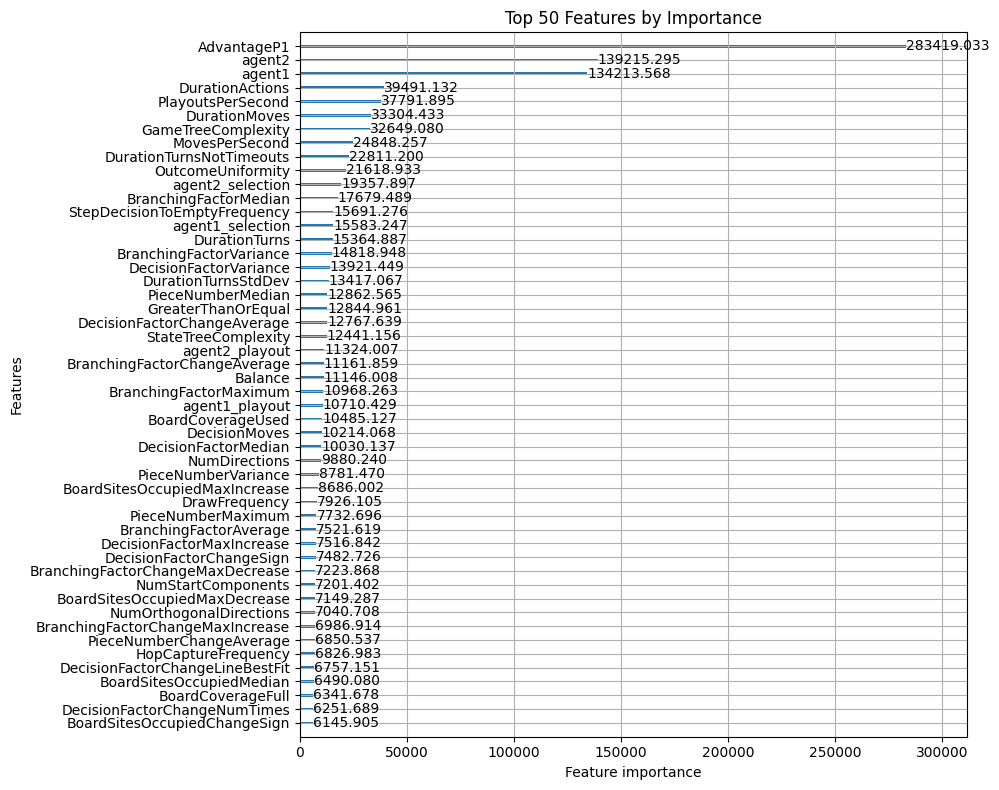

Fold 5 - RMSE: 0.4254064176177366
List of oof scores: [0.42967570203589445, 0.4161412328704214, 0.42033993795942926, 0.4133295941706173, 0.4254064176177366]
Average oof score: 0.42097857693081975


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4257
Score: 0.4477
Score: 0.4341
Score: 0.4354
Score: 0.4048
Average CV1 Score: 0.4296

CV2 OOF Scores:
Score: 0.4154
Score: 0.4018
Score: 0.4322
Score: 0.4366
Score: 0.4244
Average CV2 Score: 0.4221

CV3 OOF Scores:
Score: 0.4297
Score: 0.4161
Score: 0.4203
Score: 0.4133
Score: 0.4254
Average CV3 Score: 0.4210


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

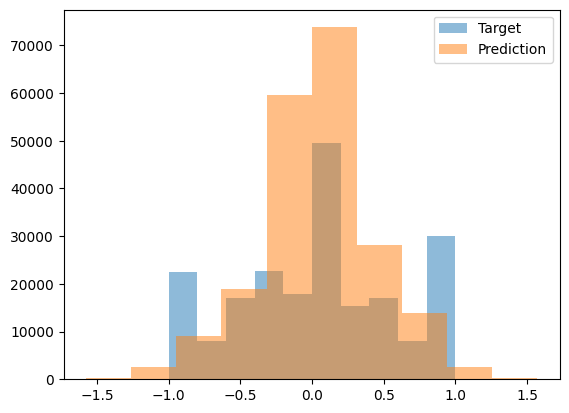

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.121428       │
│ 233235 ┆ -0.156919      │
│ 233236 ┆ -0.054666      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***